# First-class Caching in Hamilton


In [1]:
from pprint import pprint

from hamilton import registry
registry.disable_autoload()
registry.load_extension("pandas")

%load_ext hamilton.plugins.jupyter_magic

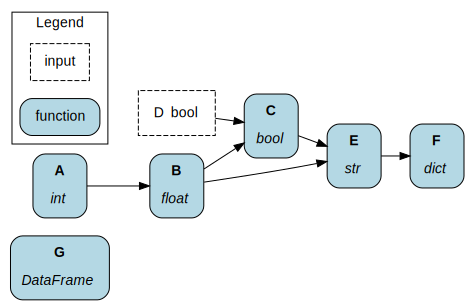

In [2]:
%%cell_to_module primitives -d
import pandas as pd
from hamilton.function_modifiers import tag

def A() -> int:
    return 7

def B(A: int) -> float:
    return float(A)

def C(B: float, D: bool) -> bool:
    return B != D

@tag(cache="pickle")
def E(C: bool, B: float) -> str:
    return "hello-world-ok" * int(B)

@tag(cache="json")
def F(E: str) -> dict:
    return {E: E*3}

@tag(cache="parquet")
def G() -> pd.DataFrame:
    return pd.DataFrame({"a": [323, 3235], "b": ["hello", "vorld"]})

In [3]:
from hamilton import driver

dr = (
    driver.Builder()
    .with_modules(primitives)
    .with_cache()
    .build()
)

In [7]:
results = dr.execute(
    ["A", "B", "C", "D", "E", "F", "G"],
    inputs=dict(D=True),
    overrides=dict(B=4)
)
print(results.keys())

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G'])


In [5]:
dr.cache.context_keys

{'A': 'eF4NxUEKwCAMBMCv9AlG48ZA6V+imx7t/28VBkaKJ5QqYa5LiXSzaMIMhuKULO2NAFnnmGDAZHQX9Hpc9/52Pj/UjxQx',
 'C': 'eF4FwcERgDAIBMBWLCGAEDLj2MvpwTP2/3O3SztyWAgrUb46ZoNSTq2Zr5xkBWD+eEKMiykEsEJHhh7X/nbdP+gBFJk=',
 'E': 'eF4FwckNgDAMBMBWKCHWOs5aQvQSfDxD/z9mAhT31VNFzDnENmoxM9L1taFMNfRcIk0HirsDbSQ6lPu6z3fq+QGUKRM7',
 'F': 'eF4FwcERwCAIBMBWUgLincBMJr2Iwafp/5ddiIc3WanjTUQ3zUYO8wEIW9AU6LL7jF1SKZ5qoPoszlJe9/lOPT9v4hJQ',
 'G': 'eF4FwckNgDAQA8BWKIEE7xEJ0YuJs8/Q/4+ZnvQQsoQl93yjsQuvZRhmBSVejiGiiXNwtThnucEJtzru/e31/NSBFG8='}

In [9]:
dr.cache.logs(dr.cache.run_id)

{'metadata_store': ['initialized'],
 'A': ['caching_behavior:resolved',
  'code::versioned',
  'in_memory_metadata::get::miss',
  'context_key::created',
  'metadata_store::get::hit',
  'result_store::get::hit',
  'context_key::created',
  'metadata_store::get::hit',
  'in_memory_metadata::set'],
 'B': ['caching_behavior:resolved',
  'code::versioned',
  'as input',
  'data::versioned',
  'in_memory_metadata::set'],
 'C': ['caching_behavior:resolved',
  'code::versioned',
  'in_memory_metadata::get::miss',
  'context_key::created',
  'metadata_store::get::hit',
  'result_store::get::hit',
  'context_key::created',
  'metadata_store::get::hit',
  'in_memory_metadata::set'],
 'E': ['caching_behavior:resolved',
  'code::versioned',
  'in_memory_metadata::get::miss',
  'context_key::created',
  'metadata_store::get::hit',
  'result_store::get::hit',
  'context_key::created',
  'metadata_store::get::hit',
  'in_memory_metadata::set'],
 'F': ['caching_behavior:resolved',
  'code::versioned',

## Caching actions
1. compute `code_version`
2. compute `data_version` for `value` using `hashing_function`
3. compute `value` by executing node with using `dependencies value`
4. create `context_key` using `code_version` and `dependencies data_version`
5. get `data_version` using `memory[node_name]`
6. set `data_version` using `memory[node_name]`
7. get `data_version` using `metadata_store[context_key]`
8. set `data_version` using `metadata_store[context_key]`
9. delete `data_version` using `metadata_store[context_key]`
10. get `value` from `result_store[data_version]`
11. set `value` from `result_store[data_version]`
12. store `value` using a materializer

## Power user
- ignore dependencies from the `context_key` function
- skip `set`/`get` operations for `metadata_store` and `result_store` 
- change the `hashing_function`
- change the `metadata_store`
- change the `result_store`
- change the `context_key` function